# Chapter 01. 금융 데이터로 소득구간 예측하기
- 21.0915

금융 데이터의 속성
금융 데이터는 주로 아래의 특성을 띄게 됩니다.

1) 이종(heterogeneous) 데이터의 결합: 데이터의 원천·형태·스케일 등이 서로 다른 성격을 가짐
2) 분포의 편향성(skewedness): 예측값과 정답이 멀리 떨어져 있으면 학습 결과의 편향(bias)이 높을 수 있음
3) 분류 레이블의 불명확성: 소득구간·신용등급·상품종류 등은 비즈니스 로직을 포함하므로 분류가 임의적 → 분석가의 해석력이 중요
4) 변수의 다중공선성(multicollinearity): 변수간 상호의존이나 상관관계가 강하게 나타날 수 있음
5) 변수의 비선형성: 변수의 영향력이 선형적이지 않을 수 있음, e.g.) 나이가 소득에 미치는 영향은?
그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

다중분류와 소득구간 예측
예측할 클래스(레이블 혹은 레벨이라고도 합니다)가 3개 이상인 경우를 다중분류 문제라고 합니다. 단순하게는 Multiclass classification, 회귀방법론을 쓴다면 Multinomial logistic regression 이라는 명칭으로 불립니다. 클래스간 위계관계(포함관계)는 동등하다고 가정하겠습니다.

소득구간 예측은 전형적인 다중분류 문제입니다. 분석에 앞서 다음과 같은 사항을 생각해 봅시다.

1) 클래스간 구분이 명확하지 않을 경우: 소득구간 구분은 어떻게 지어야 하며, 클래스는 몇 개로 결정해야 할까요?
2) 클래스간 구분에 순서가 있을 경우: 정확하게 말하자면 각 소득구간은 순서가 있는(ordinal) 클래스로 보아야 할 것입니다.
3) 특정 클래스에 해당하는 값이 부족할 경우: 고소득 구간 고객 수와 중소득 구간 고객의 수가 현저히 차이가 날 때 어떻게 해결할까요?
다중분류 문제는 이진분류 대비 아래와 같은 추가 고려사항이 있습니다.

1) 모델 구현할 때 주의사항: 변수의 원-핫-인코딩 처리, 목적함수의 결정 등
2) 결과 해석할 때 주의사항: 정확도(Accuracy), F1 스코어, Confusion Matrix 등
실제 분석에서 자세히 다루도록 하겠습니다.
학습목표
1) 이진분류·다중분류 모델의 이해
2) 선형 기반·트리 기반 분류모델의 이해
3) 변수 처리 방법에 대한 이해
4) 분류모델 결과를 해석하는 방법 습득
5) 평가결과를 바탕으로 모델을 개선하는 방법 습득

## Step 1. 예측할 데이터 불러오기
### 데이터 소개<br>
이번 주제는 US Census Bureau에서 수집하고 UCI에서 배포한 US Adult Income 데이터셋에 강사가 자체 제작한 모의 변수를 추가·수정한 데이터를 사용합니다.<br>
첫번째로 사용할 데이터는 US Adult Income 데이터셋이며 컬럼은 아래와 같습니다.<br>
- age : 나이
- workclass: 직업구분
- education: 교육수준
- education.num: 교육수준(numerically coded)
- marital.status: 혼인상태
- occupation : 직업
- relationship: 가족관계
- race: 인종
- sex: 성별
- capital.gain: 자본이득
- capital.loss: 자본손실
- hours.per.week: 주당 근로시간
- income : 소득 구분

In [3]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
datapath = 'https://github.com/mchoimis/financialML/raw/main/income/'
df = pd.io.parsers.read_csv(datapath + 'income.csv')        # 미국 성인 소득
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
df['marital.status'].unique()
#'Widowed', 'Divorced', 'Separated','Never-married','Married-civ-spouse''Married-spouse-absent''Married-AF-spouse'
#'사별',    '이혼',     '별거',     '미혼',         '결혼-시민-배우자', '결혼 배우자 부재',     '기혼-AF-배우자'

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [6]:
df['relationship'].unique()

array(['Not-in-family', 'Unmarried', 'Own-child', 'Other-relative',
       'Husband', 'Wife'], dtype=object)

In [7]:
df['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [8]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
# 데이터 형태 확인

print(df.shape)
print(df.columns)

(32561, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## 문제 03. 데이터 확인하기

In [11]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [12]:
# 결측치를 NaN으로 바꾸기
df[df=='?'] = np.nan

In [13]:
# 최빈값으로 결측치 채우기
for col in ['workclass', 'occupation', 'native.country']:
    # 이어서 작성해주세요
    df[col].fillna(df[col].mode()[0], inplace=True)

In [14]:
# 결과 확인하기

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [15]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

## Step 2. Feature Engineering
### 문제 04. 인풋 피처와 타겟값 만들기

In [16]:
X =  df.drop(['income', 'education', 'fnlwgt'], axis = 1)
y =  df['income']


In [17]:
X.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education.num   32561 non-null  int64 
 3   marital.status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital.gain    32561 non-null  int64 
 9   capital.loss    32561 non-null  int64 
 10  hours.per.week  32561 non-null  int64 
 11  native.country  32561 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [19]:
y.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

### 문제 05. 원 데이터를 training set과 test set으로 나누기

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
12367,27,Local-gov,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
7054,38,Federal-gov,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


In [21]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
12367,27,Local-gov,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
7054,38,Federal-gov,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


### 문제 06. 범주변수 처리하기

In [22]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        X_train[feature] =  le.fit_transform(X_train[feature]) 
        X_test[feature] =   le.transform(X_test[feature]) 

### 문제 07. 범주변수 처리 결과 확인하기

참고: 범주변수의 처리<br>
범주변수의 처리 방법은 크게 2가지로 나눌 수 있습니다.

- 클래스를 숫자로 변환
- 원-핫-인코딩(더미코딩)

In [23]:
# 변환된 범주변수 컬럼 확인하기(X_train)
X_train[categorical].head(3)

,workclass,marital.status,occupation,relationship,race,sex,native.country
32098,6,2,3,5,4,0,38
25206,1,2,6,0,4,1,38
23491,3,4,3,1,4,0,38


In [24]:
# 변환된 범주변수 컬럼 확인하기(X_test)
X_test[categorical].head(3)

,workclass,marital.status,occupation,relationship,race,sex,native.country
22278,3,6,11,4,4,0,38
8950,3,4,5,3,4,0,38
7838,3,4,7,1,1,0,39


### 문제 08. 피처 스케일 조정하기

참고: scikit-learn에서 제공하는 피처 스케일러(scaler)
- StandardScaler: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- RobustScaler: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- MinMaxScaler: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- Normalizer: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다.

반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.

스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다. 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

In [25]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [26]:
# 스케일 조정된 X_train 데이터 확인하기

X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,6,13,2,3,5,4,0,0,0,20,38
25206,39,1,9,2,6,0,4,1,0,0,38,38
23491,42,3,10,4,3,1,4,0,0,0,40,38
12367,27,1,9,4,4,3,4,1,0,0,40,38
7054,38,0,14,2,3,0,4,1,0,0,40,38


In [27]:
X_train_scaled.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.101484,2.600478,1.133894,-0.402341,-0.782234,2.214196,0.39298,-1.430470,-0.145189,-0.217407,-1.662414,0.262317
1,0.028248,-1.884720,-0.423425,-0.402341,-0.026696,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.200753,0.262317
2,0.247956,-0.090641,-0.034095,0.926666,-0.782234,-0.276689,0.39298,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
3,-0.850587,-1.884720,-0.423425,0.926666,-0.530388,0.968753,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317
4,-0.044989,-2.781760,1.523223,-0.402341,-0.782234,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317


In [28]:
print(min(X_train['age']))
print(max(X_train['age']))
print(np.mean(X_train['age']))
print(np.var(X_train['age']))
print('\n')
print(min(X_test['age']))
print(max(X_test['age']))
print(np.mean(X_test['age']))
print(np.var(X_test['age']))

17
90
38.61429448929449
186.44402697680837


17
90
38.505476507319074
185.14136114308525


In [29]:
X_train.describe()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
count,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000
mean,38.614294,3.101044,10.087575,2.605476,6.106002,1.444323,3.666462,0.671727,1064.423043,87.756581,40.472227,36.411241
std,13.654750,1.114802,2.568573,1.504916,3.970769,1.605890,0.848759,0.469595,7331.442737,403.660431,12.315027,6.056766
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,3.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000
50%,37.000000,3.000000,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000
75%,48.000000,3.000000,12.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000
max,90.000000,7.000000,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,40.000000


In [30]:
print(min(X_train_scaled['age']))
print(max(X_train_scaled['age']))
print(np.mean(X_train_scaled['age']))
print(np.var(X_train_scaled['age']))
print('\n')
print(min(X_test_scaled['age']))
print(max(X_test_scaled['age']))
print(np.mean(X_test_scaled['age']))
print(np.var(X_test_scaled['age']))

-1.5829486507307393
3.7632934651328265
1.5671010251132251e-16
0.9999999999999883


-1.5829486507307393
3.7632934651328265
-0.007969414769866536
0.9930130996694251


In [31]:
X_train_scaled.describe()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
count,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04
mean,1.567101e-16,9.820276e-17,-3.105770e-16,1.484646e-15,-2.803518e-16,4.271865e-16,-6.634401e-16,-4.658825e-16,-9.285015e-16,-9.243220e-16,5.219265e-16,1.411647e-15
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.582949e+00,-2.781760e+00,-3.538063e+00,-1.731347e+00,-1.537772e+00,-8.994102e-01,-4.319887e+00,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.205279e+00,-6.011796e+00
25%,-7.773505e-01,-9.064068e-02,-4.234251e-01,-4.023406e-01,-7.822339e-01,-8.994102e-01,3.929802e-01,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.623172e-01
50%,-1.182248e-01,-9.064068e-02,-3.409539e-02,-4.023406e-01,-2.669619e-02,-2.766891e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.623172e-01
75%,6.873733e-01,-9.064068e-02,7.445640e-01,9.266662e-01,7.288415e-01,9.687533e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,3.676705e-01,2.623172e-01
max,3.763293e+00,3.497518e+00,2.301883e+00,2.255673e+00,1.736225e+00,2.214196e+00,3.929802e-01,6.990710e-01,1.349485e+01,1.057408e+01,4.752654e+00,5.925337e-01


## Step 3. 선형 분류모델 구현하기

### 문제 10. 원 데이터를 이용하여 Logistic Regression 모델 돌려보기

In [32]:
# Feature scaling 전 원본 데이터
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg =  LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

### 문제 11. 원 데이터를 이용한 Logistic Regression 모델의 정확도 확인하기

In [33]:
y_pred =  logreg.predict(X_test)
# logreg_score =  accuracy_score(y_test, y_pred)
print('Logistic Regression accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score: 0.8057


### 문제 12. 스케일 조정된 데이터를 이용하여 Logistic Regression 모델 돌려보기

In [34]:
# Feature scaling 후 변환 데이터
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train) ##

LogisticRegression()

### 문제 13. 스케일 조정된 데이터를 이용한 Logistic Regression 모델의 정확도 확인하기

In [35]:
y_pred = logreg.predict(X_test_scaled)  ##
logreg_score =  accuracy_score(y_test, y_pred)
print('Logistic Regression (scaled data) accuracy score: {0:0.4f}'. format(logreg_score))

Logistic Regression (scaled data) accuracy score: 0.8222


In [36]:
# 예측된 값 확인하기
y_pred

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      dtype=object)

### 문제 14. 스케일 조정된 데이터를 이용한 Logistic Regression 모델 분류결과 확인하기

In [37]:
from sklearn.metrics import classification_report

cm_logreg =  classification_report(y_test, y_pred) 
print(cm_logreg)

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



## Step 4. 트리기반 분류모델의 구현

### 문제 15. Random Forest 모델 구현하고 정확도 확인하기

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
criterion='gini' # 분할의 품질을 측정하는 기능입니다. 지원되는 기준은 Gini 불순물에 대한 "gini" 및 정보 이득에 대한 "엔트로피"입니다. (정보 이득)
n_estimators=100 # The number of trees in the forest.

In [40]:
y_pred = rfc.predict(X_test) 
rfc_score =  accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rfc_score ))

Random Forest Model accuracy score : 0.8479


### 문제 16. Random Forest 모델의 Confusion Matrix 확인하기

In [41]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Binary Labels \n')
# print('Confusion Matrix for Binary Labels\n')
# print('Actual class')
# print('Predicted', '[[True Positive', 'False Positive]')
# print('         ', '[False Negative', 'True Negative]]')
print(cm)

Confusion Matrix for Binary Labels 

[[6845  565]
 [ 921 1438]]


In [42]:
# Confusion Matrix에서 Recall과 Precision 계산하기

print('\nRecall for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[0,1])
print('\nPrecision for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[1,0])
print('\nRecall for Class [>50K] = ', cm[1,1], '/' , cm[1,0] + cm[1,1])
print('\nPrecision for Class [>50K] = ', cm[1,1], '/' , cm[0,1] + cm[1,1])


Recall for Class [<=50K] =  6845 / 7410

Precision for Class [<=50K] =  6845 / 7766

Recall for Class [>50K] =  1438 / 2359

Precision for Class [>50K] =  1438 / 2003


### 문제 17. Random Forest 모델의 분류결과 확인하기

In [43]:
from sklearn.metrics import classification_report

cm_rfc =  classification_report(y_test, y_pred)
print(cm_rfc)

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



## Step 5. 부스팅 기반 분류모델의 구현

### 부스팅(Boosting) 모델 개요
- 부스팅은 여러 트리의 적합 결과를 합하는 앙상블 알고리즘의 하나로, 이 때 sequential의 개념이 추가되어 있습니다. 즉 연속적인 weak learner, 바로 직전 weak learner의 error를 반영한 현재 weak learner를 잡겠다는 것입니다. 이 아이디어는 Gradient Boosting Model(GBM)에서 loss를 계속 줄이는 방향으로 weak learner를 잡는다는 개념으로 확장됩니다.
- 부스팅 계열 모델은 AdaBoost, Gradient Boosting Model(GBM), XGBoost, LightGBM 등이 있습니다.

### 문제 18. Gradient Boosting 모델 구현하고 정확도 확인하기

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =  GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)
y_pred =  gbc.predict(X_test)
gbc_score =  accuracy_score(y_test, y_pred)
print('Gradient Boosting accuracy score : {0:0.4f}'.format(gbc_score))

Gradient Boosting accuracy score : 0.8621


### 문제 19. Gradient Boosting 모델의 분류결과 확인하기

In [45]:
from sklearn.metrics import classification_report

cm_gbc =  classification_report(y_test, y_pred)
print(cm_gbc)

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



### 문제 20. Light GBM 구현하고 정확도 확인하기

In [46]:
!pip install lightgbm

In [47]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier(random_state=0)
lgbm.fit(X_train, y_train)
y_pred =  lgbm.predict(X_test)

lgbm_score =  accuracy_score(y_test, y_pred)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8696


### 문제 21. Light GBM 분류결과 확인하기

In [48]:
from sklearn.metrics import classification_report

cm_lgbm =  classification_report(y_test, y_pred)
print(cm_lgbm)

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      7410
        >50K       0.77      0.65      0.71      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



### 문제 22. 요약: 소득 이진분류 예측모델의 정확도 비교하기

In [49]:
print ('Accuracy Comparisons for Binary Models\n')
print ('logreg_score:', '{0:0.5f}'.format(logreg_score))
print ('rfc_score   :', '{0:0.5f}'.format(rfc_score))
print ('gbc_score   :', '{0:0.5f}'.format(gbc_score ))
print ('lgbm_score  :', '{0:0.5f}'.format(lgbm_score))

Accuracy Comparisons for Binary Models

logreg_score: 0.82219
rfc_score   : 0.84789
gbc_score   : 0.86211
lgbm_score  : 0.86959


### 문제 23. 최종 이진분류 모델 비교하기

In [51]:
print ('Classification Comparions for Binary Models\n')
print ('logreg_score:', '{0:0.4f}'.format(logreg_score))
print (cm_logreg)
print ('rfc_score   :', '{0:0.4f}'.format(rfc_score))
print (cm_rfc)

Classification Comparions for Binary Models

logreg_score: 0.8222
              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769

rfc_score   : 0.8479
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [52]:
print ('gbc_score   :', '{0:0.4f}'.format(gbc_score ))
print (cm_gbc)
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print (cm_lgbm)

gbc_score   : 0.8621
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769

lgbm_score  : 0.8696
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      7410
        >50K       0.77      0.65      0.71      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



## Step 6. 다중분류 모델의 구현
### 데이터 소개
- 두번째로 쓸 데이터는 앞에서 사용한 US Adult 데이터에 모의로 생성한 금융 변수를 수정(+)·추가(++)한 것이며, 컬럼은 다음과 같습니다.

- age : 나이
- workclass: 직업구분
- education: 교육수준
- education.num: 교육수준(numerically coded)
- marital.status: 혼인상태
occupation : 직업
- relationship: 가족관계
- sex: 성별
- capital.gain: 자본이득
- capital.loss: 자본손실
- hours.per.week: 주당 근로시간
- spending.groc: 식료품 소비 금액(continuous) ++
- spending.med: 병의원 소비 금액(continuous) ++
- spending.trav: 여행 레저 소비 금액(continuous) ++
- income : 소득 이진구분( <=50K: 0, >50K: 1 ) +
- income.num : 소득금액(continuous) ++

## 문제 24. 데이터 불러오기

In [53]:
data =  pd.read_csv(datapath + 'income_ext.csv')
print(data.shape)
print(data.columns)

(32561, 19)
Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'spend.groc', 'spend.med', 'spend.trav', 'asset',
       'balance', 'native.country', 'income', 'income.num'],
      dtype='object')


In [54]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583


### Light GBM 개요

Decision Tree의 앙상블 모델인 Gradient Boosting Decision Tree (GBDT)는 실무에서 XGboost(eXtreme Gradient Boosting) 등으로도 알려져 있습니다. 각각의 반복에서 GBDT는 음의 기울기(Residual Error)를 적합함으로써 Decision Tree를 학습시키게 됩니다.
그러나 고차원 대용량 데이터에서는 너무 많은 시간의 소모가 발생하였는데, 왜냐하면 모든 가능한 분할점에 대해 정보 획득(information gain)을 평가하기 위해 데이터 전부를 스캔해야 했기 때문입니다.
Light GBM은 이러한 Gradient Boosting 모델의 단점을 극복하기 위해 샘플링 등의 기법을 이용하여 스캔하는 데이터 양을 줄임으로써 분석 시간을 획기적으로 단축시킨 방법론입니다.
LGBM은 범주변수가 많은 정형 데이터와 다중분류에 유용한 알고리즘으로, 간단한 원리를 알아두시면 도움이 될 것입니다.

- 참고링크: Light GBM: A Highly Efficient Gradient Boosting Decision Tree (NIPS 2017) [https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html ]

In [55]:
data.shape

(32561, 19)

### Light GBM 파라미터 설명
- objective : 목적함수, regression, binary, multiclass 가능
- categorical_feature : 범주변수임을 선언
- max_cat_group : 범주형 변수가 많을 때 과적합을 방지하는 분기 포인트를 찾아서 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾게 됨, 기본값은 64
- boosting: 부스팅 방법, 기본값은 gbdt(gradient boosting decision tree)이며 샘플링을 이용하는 goss(Gradient-based One-Side Sampling), 딥러닝의 드롭아웃과 같은 dart (Dropouts meet Multiple Additive Regression Trees), rf (Random Forest) 등의 기법 선택 가능
- learning_rate : 학습율, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 결정
- early_stopping_round : 더 이상 validation 데이터에서 성능 향상이 없으면 멈추게끔 하는 단위
- metric: loss 측정 기준, binary_logloss, multi_logloss, mae, rmse, auc, cross_entropy 등이 있다

## 문제 25. 데이터 확인하기

In [56]:
# Create raw dataset for input
X = data.drop(['education', 'income', 'income.num'], axis=1)   # Drop columns
y = data['income.num']  # Choose column

In [57]:
# X raw 데이터 확인하기

X.head()

,age,workclass,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country
0,90,?,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States
2,66,?,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States


In [58]:
# y raw 데이터 확인하기

y.head()

0    43713
1    33113
2    31652
3    55087
4    85583
Name: income.num, dtype: int64

## 문제 26. 다중분류 클래스 생성하기

In [59]:
def value_change(x):
    if x <= 10000: return 0
    if x >  10000 and x <= 20000 : return 1
    if x >  20000 and x <= 30000 : return 2
    if x >  30000 and x <= 40000 : return 3
    if x >  40000 and x <= 50000 : return 4
    if x >  50000 and x <= 60000 : return 5
    if x >  60000 and x <= 70000 : return 6
    if x >  70000 and x <= 80000 : return 7
    if x >  80000 and x <= 90000 : return 8
    if x >  90000 and x <= 100000 : return 9
    return 10                          
                                       ## Define function

y = y.apply(lambda x: value_change(x))  ## Apply Lambda function

In [60]:
# 생성한 레이블 확인하기
y.unique()

array([ 4,  3,  5,  8,  7,  9,  2,  6,  1,  0, 10], dtype=int64)

In [61]:
y.value_counts()

6     3318
9     3310
7     3276
4     3273
8     3257
1     3250
5     3246
3     3233
2     3180
0     3176
10      42
Name: income.num, dtype: int64

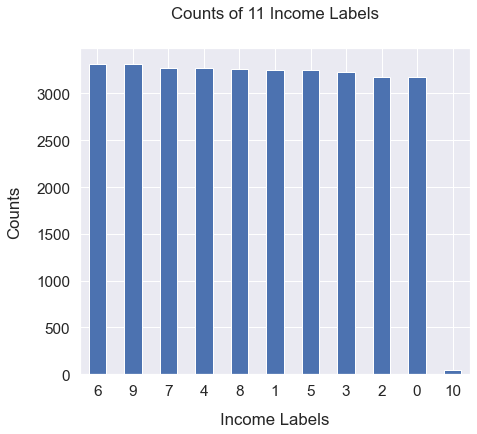

In [62]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 11 Income Labels\n", y=1.02);

## 문제 27. Feature Engineering

In [63]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        x_train[feature] =  le.fit_transform(x_train[feature])
        x_test[feature] =  le.transform(x_test[feature])

In [65]:
x_train[categorical].head()

,workclass,marital.status,occupation,relationship,sex,native.country
32098,7,2,4,5,0,39
25206,2,2,7,0,1,39
23491,4,4,4,1,0,39
12367,2,4,5,3,1,39
7054,1,2,4,0,1,39


## 문제 28. Light GBM 을 이용하여 다중분류 구현하기

In [66]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier( )
lgbm.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 문제 29. Light GBM 다중분류 결과 확인하기: Accuracy, Confusion Matrix, Heatmap

In [68]:
## 정확도 구하기
y_pred1 =  lgbm.predict(x_test)

lgbm_score =  accuracy_score(y_test, y_pred1)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8151


In [69]:
pd.DataFrame(y_test).head(10)

,income.num
22278,6
8950,6
7838,7
16505,3
19140,2
12319,7
28589,7
10000,1
28530,3
24237,6


In [70]:
pd.DataFrame(y_pred1).head(10)

,0
0,6
1,6
2,6
3,3
4,3
5,7
6,7
7,1
8,3
9,6


In [71]:
## Confusion Matrix 확인하기
from sklearn.metrics import confusion_matrix
cm1 =  confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 11-class Labels\n')
print(cm1)

LGBM Confusion Matrix for 11-class Labels

[[917  46   5   8   1   0   4   6   0   1   0]
 [ 36 862  50  11   7   1   1   1   0   0   0]
 [ 18  36 810  45  10   1   3   3   0   4   0]
 [ 13   7  66 847  60  11   5   4   3   3   0]
 [  8  10  11  65 773  64  20   6   7   5   0]
 [  8   6  17  15  81 755  88  18   9   5   0]
 [  8   8   9   8  12  83 714  79  13  17   0]
 [ 11   6  12   3  10   9  80 736  93  22   0]
 [  7   7   8   7   9  12   8 106 737  77   0]
 [  7   6   6  10  14   8   9  28  67 812   2]
 [  0   0   0   0   0   0   0   0   0  12   0]]


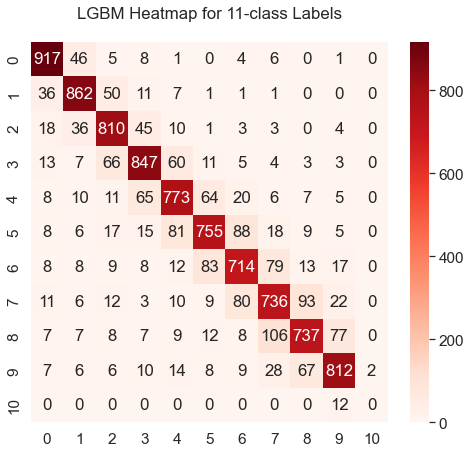

In [72]:
## 히트맵으로 시각화하기
plt.figure(figsize=[8,7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.title('LGBM Heatmap for 11-class Labels\n')
plt.show()

In [73]:
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))
print('\n')
print(classification_report(y_test, y_pred1))

LGBM Model accuracy score : 0.8151


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       988
           1       0.87      0.89      0.88       969
           2       0.81      0.87      0.84       930
           3       0.83      0.83      0.83      1019
           4       0.79      0.80      0.79       969
           5       0.80      0.75      0.78      1002
           6       0.77      0.75      0.76       951
           7       0.75      0.75      0.75       982
           8       0.79      0.75      0.77       978
           9       0.85      0.84      0.84       969
          10       0.00      0.00      0.00        12

    accuracy                           0.82      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.82      0.81      9769



## 문제 30. Random Forest 모델로 다중분류 구현하고 정확도 확인하기

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc =  RandomForestClassifier() 
rfc.fit(x_train, y_train) 

RandomForestClassifier()

In [75]:
y_pred =  rfc.predict(x_test)
rfc_score =  accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rfc_score))

Random Forest Model accuracy score : 0.7653


모델 개선 --> 정확도 개선, F1 스코어 개선 <- 모델 변경, 모델의 파라미터 변경, 데이터 변경(처리, 피처 엔지니어링, 정제, 아웃라이어 제거, 변수 추가) 11개 --> ? 개

# Step 7. 다중분류 모델의 평가와 개선

## 문제 31. Random Forest 다중분류 모델의 정확도 확인하기

In [76]:
## 이전 Step 복습
y_pred = rfc.predict(x_test)
rfc_score = accuracy_score(y_test, y_pred)
print('Randoom Forest Model accuracy score : {0:0.4f}'. format(rfc_score)) 

Randoom Forest Model accuracy score : 0.7653


평가방법: 정확도(exact match), 인접 정확도 1, 2, 3, ... 10 <-- 멀티 클래스 분류 레이블의 임의성, 불명확성  // [1000-2000] [1234-2194] 

## 문제 32. Random Forest 다중분류 모델의 인접정확도 구하기

In [77]:
## 인접 정확도의 계산
precise_accuracy =  np.sum(y_pred==y_test) / len(y_pred)
adjacent_accuracy =  np.sum(np.abs(y_pred - y_test) <= 1) / len(y_pred)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.7653
adjacent accuracy: 0.9307


## 문제 33. Random Forest 다중분류 모델의 Confusion Matrix 확인하기

In [78]:
print(cm1) # light gbm 

[[917  46   5   8   1   0   4   6   0   1   0]
 [ 36 862  50  11   7   1   1   1   0   0   0]
 [ 18  36 810  45  10   1   3   3   0   4   0]
 [ 13   7  66 847  60  11   5   4   3   3   0]
 [  8  10  11  65 773  64  20   6   7   5   0]
 [  8   6  17  15  81 755  88  18   9   5   0]
 [  8   8   9   8  12  83 714  79  13  17   0]
 [ 11   6  12   3  10   9  80 736  93  22   0]
 [  7   7   8   7   9  12   8 106 737  77   0]
 [  7   6   6  10  14   8   9  28  67 812   2]
 [  0   0   0   0   0   0   0   0   0  12   0]]


In [79]:
from sklearn.metrics import confusion_matrix
cm2 =  confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 11-class Labels\n')
print(cm2)

Random Forest Confusion Matrix for 11-class Labels

[[931  47   5   1   1   0   2   1   0   0   0]
 [ 54 834  65  11   1   1   3   0   0   0   0]
 [ 26  75 765  45   9   4   4   0   1   1   0]
 [ 17  18  99 766  90  12   6   2   6   3   0]
 [ 15  17  18  82 719  86  16   5   5   6   0]
 [ 10  11  21  21 103 704 107  10   7   8   0]
 [ 11   9  13  13  17  95 691  89   4   9   0]
 [ 13   7   6   8  15  17 114 683  99  20   0]
 [  8  12   2   7  15  13  24 136 651 110   0]
 [ 11   7  11  11  17  20  17  34 109 732   0]
 [  0   0   0   0   0   0   0   1   0  11   0]]


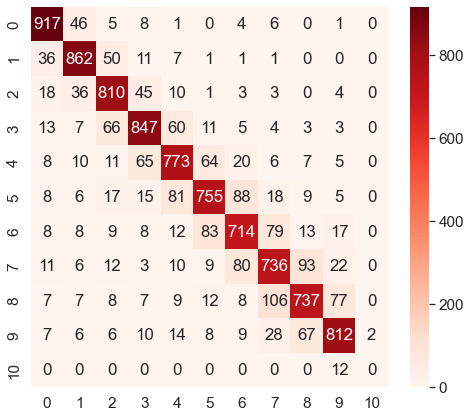

In [80]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.show()

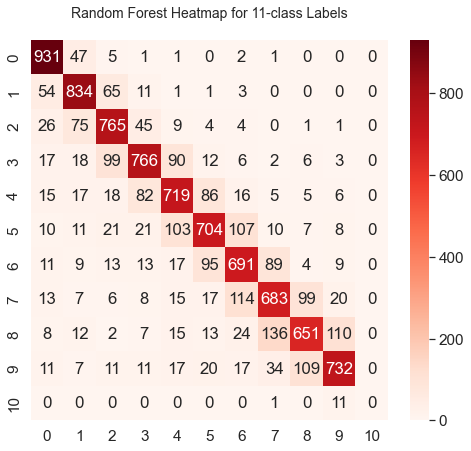

In [81]:
## Seaborn Heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

## 문제 34. Random Forest 다중분류 모델의 분류결과 확인하기

In [82]:
from sklearn.metrics import classification_report

print('Random Forest precise  accuracy for 11 labels: {0:0.4f}'. format(precise_accuracy))
print('Random Forest adjacent accuracy for 11 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred ))

Random Forest precise  accuracy for 11 labels: 0.7653
Random Forest adjacent accuracy for 11 labels: 0.9307


              precision    recall  f1-score   support

           0       0.85      0.94      0.89       988
           1       0.80      0.86      0.83       969
           2       0.76      0.82      0.79       930
           3       0.79      0.75      0.77      1019
           4       0.73      0.74      0.74       969
           5       0.74      0.70      0.72      1002
           6       0.70      0.73      0.71       951
           7       0.71      0.70      0.70       982
           8       0.74      0.67      0.70       978
           9       0.81      0.76      0.78       969
          10       0.00      0.00      0.00        12

    accuracy                           0.77      9769
   macro avg       0.69      0.70      0.69      9769
weighted avg       0.76      0.77      0.76      9769



## 문제 35. 적절한 클래스 수로 변환하여 모델 개선하기

In [83]:
def value_change(x):
    if x <= 20000: return 0
    if x >  20000 and x <= 50000 : return 1
    if x >  50000 and x <= 70000 : return 2
    if x >  70000 and x <= 90000 : return 3 
    return 4
                                       ## Define new function
y = data['income.num'].apply(lambda x: value_change(x))   ## Apply Lambda function
y.value_counts()

1    9686
2    6564
3    6533
0    6426
4    3352
Name: income.num, dtype: int64

In [84]:
y.value_counts().sum()

32561

In [85]:
9686 / 32561

0.29747243635023496

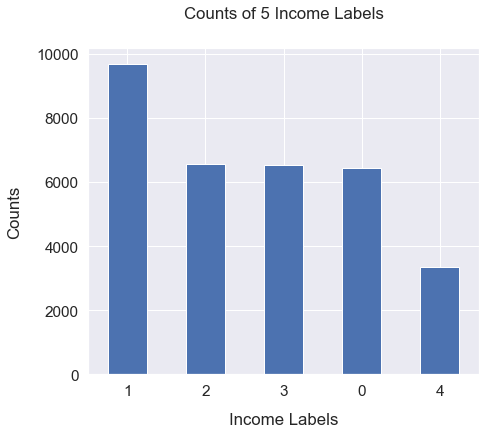

In [86]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 5 Income Labels\n", y=1.02);

## 문제 36. Feature Engineering

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        x_train[feature] = le.fit_transform(x_train[feature])
        x_test[feature] = le.transform(x_test[feature])

## 문제 37. 변경한 클래스를 이용한 Random Forest 다중분류 모델의 개선결과 확인하기

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(random_state=0)
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [89]:
## Confusion Matrix 확인하기
y_pred =  rfc.predict(x_test)
cm3 =  confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 5-class Labels\n')
print(cm3)

Random Forest Confusion Matrix for 5-class Labels

[[1811  144    2    0    0]
 [ 105 2721   84    8    0]
 [  31  194 1609  118    1]
 [  26   81  134 1680   39]
 [  13   56   29  253  630]]


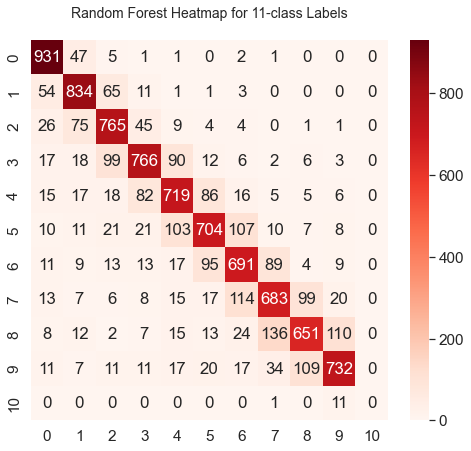

In [90]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

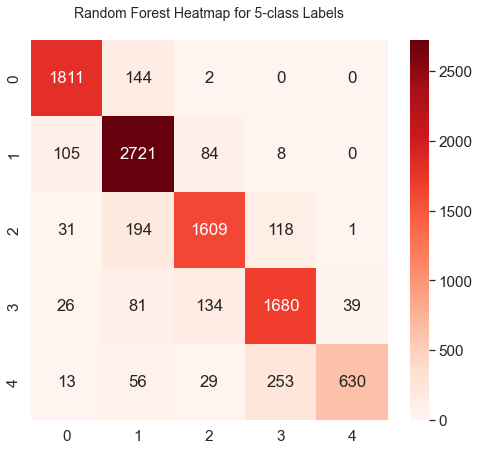

In [91]:
# Heatmap 그려보기

plt.figure(figsize=[8,7])
sns.heatmap(cm3, cmap="Reds", annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

In [92]:
## Accruacy Evaluation
precise_accuracy =  np.sum(y_pred==y_test) / len(y_pred) # exact_match
adjacent_accuracy =  np.sum(np.abs(y_pred - y_test) <=1) / len(y_pred)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.8651
adjacent accuracy: 0.9747


In [93]:
## 2가지 Accruacy 스코어의 비교
print('Random Forest precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy))
print('Random Forest adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred))

Random Forest precise  accuracy for 5 labels: 0.8651
Random Forest adjacent accuracy for 5 labels: 0.9747


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769



## 문제 38. 변경한 클래스를 이용한 Ligth GBM 다중분류 모델의 개선결과 확인하기

In [94]:
lgbm =  LGBMClassifier(random_state=0)
lgbm.fit(x_train, y_train)
y_pred1 =  lgbm.predict(x_test)

lgbm_score1 = accuracy_score(y_test, y_pred1 )
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score1))

LGBM Model accuracy score : 0.9030


In [95]:
## Confusion Matrix 구하기

cm4 =  confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 5-class Labels\n')
print(cm4)


LGBM Confusion Matrix for 5-class Labels

[[1858   93    2    4    0]
 [  75 2756   70   13    4]
 [  26  129 1700   95    3]
 [  24   54  106 1717   59]
 [  13   35   24  119  790]]


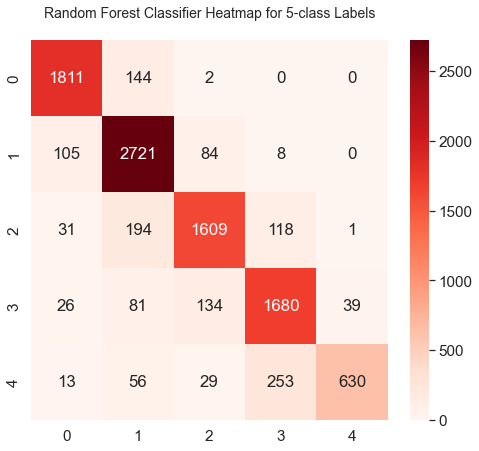

In [96]:
# seaborn를 이용한 heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm3, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Classifier Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

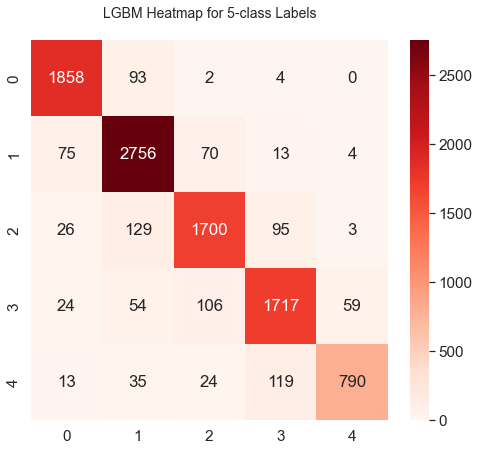

In [97]:
# seaborn를 이용한 heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm4, cmap='Reds', annot=True, fmt='.0f')
plt.title('LGBM Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

In [98]:
## Accuracy Evalaution
precise_accuracy1 =  np.sum(y_pred1 == y_test) / len(y_pred1) # exact_match
adjacent_accuracy1 =  np.sum(np.abs(y_pred1 - y_test) <= 1) / len(y_pred1) 

print('LGBM precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy1))
print('LGBM adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy1))
print('\n')
print(classification_report(y_test, y_pred1))

LGBM precise  accuracy for 5 labels: 0.9030
LGBM adjacent accuracy for 5 labels: 0.9793


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.90      0.94      0.92      2918
           2       0.89      0.87      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.92      0.81      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0.90      9769
weighted avg       0.90      0.90      0.90      9769



## 문제 39. 요약: 소득 다중분류 예측모델의 결과 비교하기

In [99]:
print ('Accuracy Comparisons for Multiclass Models\n')
print ('rfc_score  (11 labels)  :', '{0:0.5f}'.format(rfc_score)) # Step 6, 문제 30
print ('rfc_score  ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy)) # Step 7, 문제 32
print ('lbgm_score (11 labels)  :', '{0:0.5f}'.format(lgbm_score)) # Step 6, 문제 29
print ('lgbm_score ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy1)) # Step 7, 문제 38

Accuracy Comparisons for Multiclass Models

rfc_score  (11 labels)  : 0.76528
rfc_score  ( 5 labels)  : 0.86508
lbgm_score (11 labels)  : 0.81513
lgbm_score ( 5 labels)  : 0.90296


In [100]:
print('LGBM Confusion Matrix')
print(cm1) # Step 6, 문제 29
print('\n')
print('Random Forest Confusion Matrix')
print(cm2) # Step 7, 문제 33

LGBM Confusion Matrix
[[917  46   5   8   1   0   4   6   0   1   0]
 [ 36 862  50  11   7   1   1   1   0   0   0]
 [ 18  36 810  45  10   1   3   3   0   4   0]
 [ 13   7  66 847  60  11   5   4   3   3   0]
 [  8  10  11  65 773  64  20   6   7   5   0]
 [  8   6  17  15  81 755  88  18   9   5   0]
 [  8   8   9   8  12  83 714  79  13  17   0]
 [ 11   6  12   3  10   9  80 736  93  22   0]
 [  7   7   8   7   9  12   8 106 737  77   0]
 [  7   6   6  10  14   8   9  28  67 812   2]
 [  0   0   0   0   0   0   0   0   0  12   0]]


Random Forest Confusion Matrix
[[931  47   5   1   1   0   2   1   0   0   0]
 [ 54 834  65  11   1   1   3   0   0   0   0]
 [ 26  75 765  45   9   4   4   0   1   1   0]
 [ 17  18  99 766  90  12   6   2   6   3   0]
 [ 15  17  18  82 719  86  16   5   5   6   0]
 [ 10  11  21  21 103 704 107  10   7   8   0]
 [ 11   9  13  13  17  95 691  89   4   9   0]
 [ 13   7   6   8  15  17 114 683  99  20   0]
 [  8  12   2   7  15  13  24 136 651 110   0]
 [ 1

In [101]:
print ('Classification Comparions for Multiclass Models\n')
print ('rfc_score   :', '{0:0.4f}'.format(rfc_score))
print (classification_report(y_test, y_pred)) # Step 7, 문제 37
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print (classification_report(y_test, y_pred1))

Classification Comparions for Multiclass Models

rfc_score   : 0.7653
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769

lgbm_score  : 0.8151
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.90      0.94      0.92      2918
           2       0.89      0.87      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.92      0.81      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0